In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap

In [18]:
# For Galvanostatic cycling 

# Variables

cv = pd.DataFrame()
l = pd.DataFrame()
d = pd.DataFrame()
cap = pd.DataFrame()
eff = pd.DataFrame()
eis_df = pd.DataFrame()

F = 96485 # C/mol
col_dep = ['Time (s)', 'Potential vs Ag/AgCl (V)', 'Current (A)', 'Charge (C)']
col_cv = ['Potential vs Li$^+$/Li (V)', 'Current (A)', 'Charge (C)', 'Time (s)', 'Current Density ($\mu$A/cm$^2$)', 'Scan']
col = ['Time', 'Time (s)', 'Current (μA)', 'Potential vs Li$^+$/Li (V)'] # 'Current Density (µA/cm$^2$)'
# col2 = [col[3], 'D (cm$^2$/s)', '$\Delta$Q', 'Cs - Co (mol/cm$^3$)'] # PITT
col_iv = ['Potential applied (V)', 'Current (A)', 'Time (s)']
potentials = ['{:.2f}'.format(round(i, 4))  for i in np.arange(3.90, 4.20, 0.05)]
formatter_0 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e3))
formatter = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e6))
formatter_1 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e4))

palette = 'viridis'

# Set up files for procedure 'Galv_Cyc_LMO_1C_Final_EIS_20230724.nox'

def setup_files(path):

    files = [os.path.join(path, i) for i in os.listdir(path)]
    folders = ['CV', 'lith', 'delith', 'EIS']
    
    for i in folders:
        if not os.path.exists(os.path.join(path, i)):
            os.mkdir(os.path.join(path, i))

    if not os.path.exists(os.path.join(path, 'EIS', 'Relaxis')):
        os.mkdir(os.path.join(path, 'EIS', 'Relaxis'))
        
    for i in os.listdir(path):
        if 'EIS_' in i:
            os.rename(os.path.join(path, i), os.path.join(path, 'EIS', i))
            
    for i in os.listdir(os.path.join(path, 'EIS')):
        if 'relaxis' in i:
            os.rename(os.path.join(path, 'EIS', i), os.path.join(path, 'EIS', 'Relaxis', i))

    for i in os.listdir(path):
        if '_lith_' in i:
            os.rename(os.path.join(path, i), os.path.join(path, 'lith', i))
        elif '_delith' in i:
            os.rename(os.path.join(path, i), os.path.join(path, 'delith', i))
        elif i != 'README.txt' and len(i) > 7:
            os.rename(os.path.join(path, i), os.path.join(path, 'CV', i))
            
    for file_path in [os.path.join(os.path.join(path, 'EIS', 'Relaxis'), i) for i in os.listdir(os.path.join(path, 'EIS', 'Relaxis'))]:
        if '_relaxis' in file_path:
            # Extract the directory and filename from the file path
            directory, filename = os.path.split(file_path)
            
            # Extract the numeric part from the filename (assuming it's the last part before '_relaxis.txt')
            numeric_part = filename.split('_relaxis.txt')[0].split('EIS_')[-1]
            
            # Convert the numeric part to a float and format it to have 2 decimals
            numeric_with_two_decimals = '{:.2f}'.format(float(numeric_part))
            
            # Create the new filename by replacing the numeric part
            new_filename = filename.replace(numeric_part, numeric_with_two_decimals)
            
            # Create the new file path
            new_file_path = os.path.join(directory, new_filename)
        
            # # Rename the file
            if file_path != new_file_path:
                
                os.rename(file_path, new_file_path)
                print(f"Renamed: {file_path} => {new_file_path}")
                
    #add zero to cycles to have them sorted
    for file_path in [os.path.join(path, 'lith', i) for i in os.listdir(os.path.join(path, 'lith')) if i != 'README.txt']:
        directory, filename = os.path.split(file_path)
        numeric_part = filename.split('_')[-1].split('.txt')[0]
        numeric_two_decimals = '{:02d}'.format(int(numeric_part))
    
        new_filename =filename[:-7] + filename[-7:-4].replace(numeric_part, numeric_two_decimals) + '.txt'  # filename.replace(numeric_part, numeric_two_decimals)
        new_file_path = os.path.join(directory, new_filename)
    
        if file_path != new_file_path:
                
            os.rename(file_path, new_file_path)
            print(f"Renamed: {file_path} => {new_file_path}")
            
    for file_path in [os.path.join(path, 'delith', i) for i in os.listdir(os.path.join(path, 'delith')) if i != 'README.txt']:
        directory, filename = os.path.split(file_path)
        numeric_part = filename.split('_')[-1].split('.txt')[0]
        numeric_two_decimals = '{:02d}'.format(int(numeric_part))

        new_filename =filename[:-7] + filename[-7:-4].replace(numeric_part, numeric_two_decimals) + '.txt'  # filename.replace(numeric_part, numeric_two_decimals)
        new_file_path = os.path.join(directory, new_filename)

        if file_path != new_file_path:            
            os.rename(file_path, new_file_path)
            print(f"Renamed: {file_path} => {new_file_path}")
    

# Methods
       
def cc(path, area, thickness, sample):
    
    cv_path = os.path.join(path, 'CV')
    lith_path = os.path.join(path, 'lith')
    delith_path = os.path.join(path, 'delith')
    cv_df = pd.DataFrame()
    
    for i in sorted(os.listdir(cv_path), reverse=True): # sorted to get initial first
        f = os.path.join(cv_path, i)
        df = pd.read_csv(f, sep = ';', skiprows = 1, names = col_cv)
        df['Current_density_calc'] = df[col_cv[1]] / area
        if '_Initial_' in i:
            df['CV'] = 'Initial'
        else:
            df['CV'] = 'Final'
        cv_df = pd.concat([cv_df, df], ignore_index=True)
        
    lithiation = pd.DataFrame()
    delithiation = pd.DataFrame()
    capacity_l = pd.DataFrame(columns = ['Capacity (mAh/cm$^3$)', 'Cycle', 'L/D'])
    capacity_d = pd.DataFrame(columns = ['Capacity (mAh/cm$^3$)', 'Cycle', 'L/D'])
    efficiency = pd.DataFrame()
    l = [os.path.join(lith_path, i) for i in os.listdir(lith_path)]
    n = 1
    for i in l:
        df = pd.read_csv(i, sep = ';')
        df = df.rename(columns={'WE(1).Potential (V)': col_cv[0], 'Capacity (mAh/cm3)': 'Capacity (mAh/cm$^3$)'})
        df['Cycle'] =  str(n) ### string or int
        df['Capacity_calc'] = -df['WE(1).Charge (C)'] /3.6 / (area * 1e-7 * thickness)
        lithiation = pd.concat([lithiation, df], ignore_index=True)
        capacity_l.loc[n] = (max(df['Capacity_calc']), n, 'Lithiation')
        n += 1
    
    d = [os.path.join(delith_path, i) for i in os.listdir(delith_path)]
    n = 1
    for i in d:
        df = pd.read_csv(i, sep = ';')
        df = df.rename(columns={'WE(1).Potential (V)': col_cv[0], 'Capacity (mAh/cm3)': 'Capacity (mAh/cm$^3$)'})
        df['Cycle'] =  n #str(n) ### string or int
        df['Capacity_calc'] = df['WE(1).Charge (C)'] /3.6 / (area * 1e-7 * thickness)
        delithiation = pd.concat([delithiation, df], ignore_index=True)
        capacity_d.loc[n] = (max(df['Capacity_calc']), n, 'Delithiation')
        n += 1
        
    capacity = pd.concat([capacity_l, capacity_d], ignore_index=True) #, capacity_d
    efficiency['Efficiency (%)'] = capacity_l['Capacity (mAh/cm$^3$)'] / capacity_d['Capacity (mAh/cm$^3$)'] * 100
    efficiency['Cycle'] = capacity_l['Cycle']
    # ###
    results = [cv_df, lithiation, delithiation, capacity, efficiency]
    for i in results:
        i['Sample'] = sample
    # ###

    return results#results #cv_df, lithiation, delithiation, capacity, efficiency

def eis(path, sample):
    
    col = ["Frequency (Hz)", "Z'", "-Z''", "Fit Frequency (Hz)", "Fit Z'", "Fit -Z''" ]
    
    path = os.path.join(path, 'EIS', 'Relaxis')
    files = [os.path.join(path, i) for i in os.listdir(path)]
    eis_data = pd.DataFrame()
    spectra = pd.DataFrame()
    m = 0
    for i in files:
        if 'Fit' in i:
            df = pd.read_csv(i, sep = '\t', skiprows = 2)
            df = df.rename(columns={'FreeVariable' : col_cv[0], 
                                    'Resistance 1: value' : 'Electrolyte Resistance ($\Omega$)', 
                                    'Resistance 2: value' : 'Charge Transfer Resistance ($\Omega$)',
                                    'CPE Q 1: value' : 'Double Layer Capacitance ($\mu$F)'})
            eis_data = pd.concat([eis_data, df], ignore_index=True)
            

        if 'Spectra' in i:
            df_s = pd.read_csv(i, skiprows=4, sep = '\t', names=col)

            df_s[col[2]] = -df_s[col[2]]
            df_s[col[5]] = -df_s[col[5]]
            df_s[col_cv[0]] = potentials[m]
            spectra = pd.concat([spectra, df_s], ignore_index=True)
            m += 1
            
    #     k += 1
    eis_data['Sample'] = sample
    spectra['Sample'] = sample
    eis = [eis_data, spectra]
    return eis #eis_data, spectra

def compare(results, add_eis_df, add_bool):
    global cv, l, d, cap, eff, eis_df
    if add_bool == True:
        cv = pd.concat([cv, results[0]], ignore_index = True)
        l = pd.concat([l, results[1]], ignore_index = True)
        d = pd.concat([d, results[2]], ignore_index = True)
        cap = pd.concat([cap, results[3]], ignore_index = True)
        eff = pd.concat([eff, results[4]], ignore_index = True)
        eis_df = pd.concat([eis_df, add_eis_df[0]], ignore_index = True)

def cc_plot(cc_df, sample, dpi):
    # Plots
    fig, ax = plt.subplots(1, 2, figsize = (15,5), dpi = dpi)
    sns.scatterplot(data = cc_df[0], x = col_cv[0], y = col_cv[4], edgecolor = None, s =1, ax = ax[0], hue = 'CV', palette = palette, legend = True)
    ax[0].set_ylabel(col_cv[4])
    ax[0].yaxis.set_major_formatter(formatter)
    # sns.scatterplot(data = cc_df[0], x = col_cv[0], y = 'Current_density_calc', edgecolor = None, s =1, ax = ax[0], hue = 'Scan', palette = palette)
 
    
    
    cmap = plt.get_cmap(palette)
    norm = Normalize(vmin=cc_df[2]['Cycle'].min(), vmax=cc_df[2]['Cycle'].max())
    num_cycles = cc_df[2]['Cycle'].max()
    # colors = cmap(norm(cc_df[1]['Cycle']))
    
    cc_df[1]['Time (h)'] = cc_df[1]['Corrected time (s)'] / 60 / 60
    cc_df[2]['Time (h)'] = cc_df[2]['Corrected time (s)'] / 60 / 60
    sns.lineplot(data = cc_df[1], x = 'Capacity_calc', y = col_cv[0], hue = 'Cycle', palette = palette, legend = False) #Corrected time (s) Capacity_calc
    sns.lineplot(data = cc_df[2], x = 'Capacity_calc', y = col_cv[0], hue = 'Cycle', legend = False, palette = palette)
    ax[1].set_xlabel('Capacity (mAh/cm$^3$)')
    fig.suptitle(sample)
    ax[1].set_ylim(3.35,4.55)
    # Color bar legend
    sm = ScalarMappable(cmap=cmap, norm = norm)
    sm.set_array([])  # An empty array is required for the ScalarMappable
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical')
    cbar.set_label('Cycles') 
    
    fig, ax = plt.subplots(dpi = dpi)
    sns.lineplot(data = cc_df[1], x = 'Time (h)', y = col_cv[0], hue = 'Cycle', palette = palette, legend = False) #Corrected time (s) Capacity_calc
    sns.lineplot(data = cc_df[2], x = 'Time (h)', y = col_cv[0], hue = 'Cycle', legend = False, palette = palette)
    ax.set_xlabel('Time (h)')
    fig.suptitle(sample)
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical')
    cbar.set_label('Cycles') 

    fig, ax = plt.subplots(1, 2, figsize = (15,5), dpi = dpi)
    sns.scatterplot(data = cc_df[3], x = 'Cycle', y = 'Capacity (mAh/cm$^3$)', hue = 'L/D', palette=palette, ax = ax[0])
    sns.scatterplot(data = cc_df[4], x = 'Cycle', y = 'Efficiency (%)', ax = ax[1])
    fig.suptitle(sample)

def eis_plot(eis_df, dpi):
    fig, ax = plt.subplots(dpi = dpi)
    sns.barplot(data = eis_df[0], x = 'Potential vs Li$^+$/Li (V)', y = 'Charge Transfer Resistance ($\Omega$)', palette = palette)


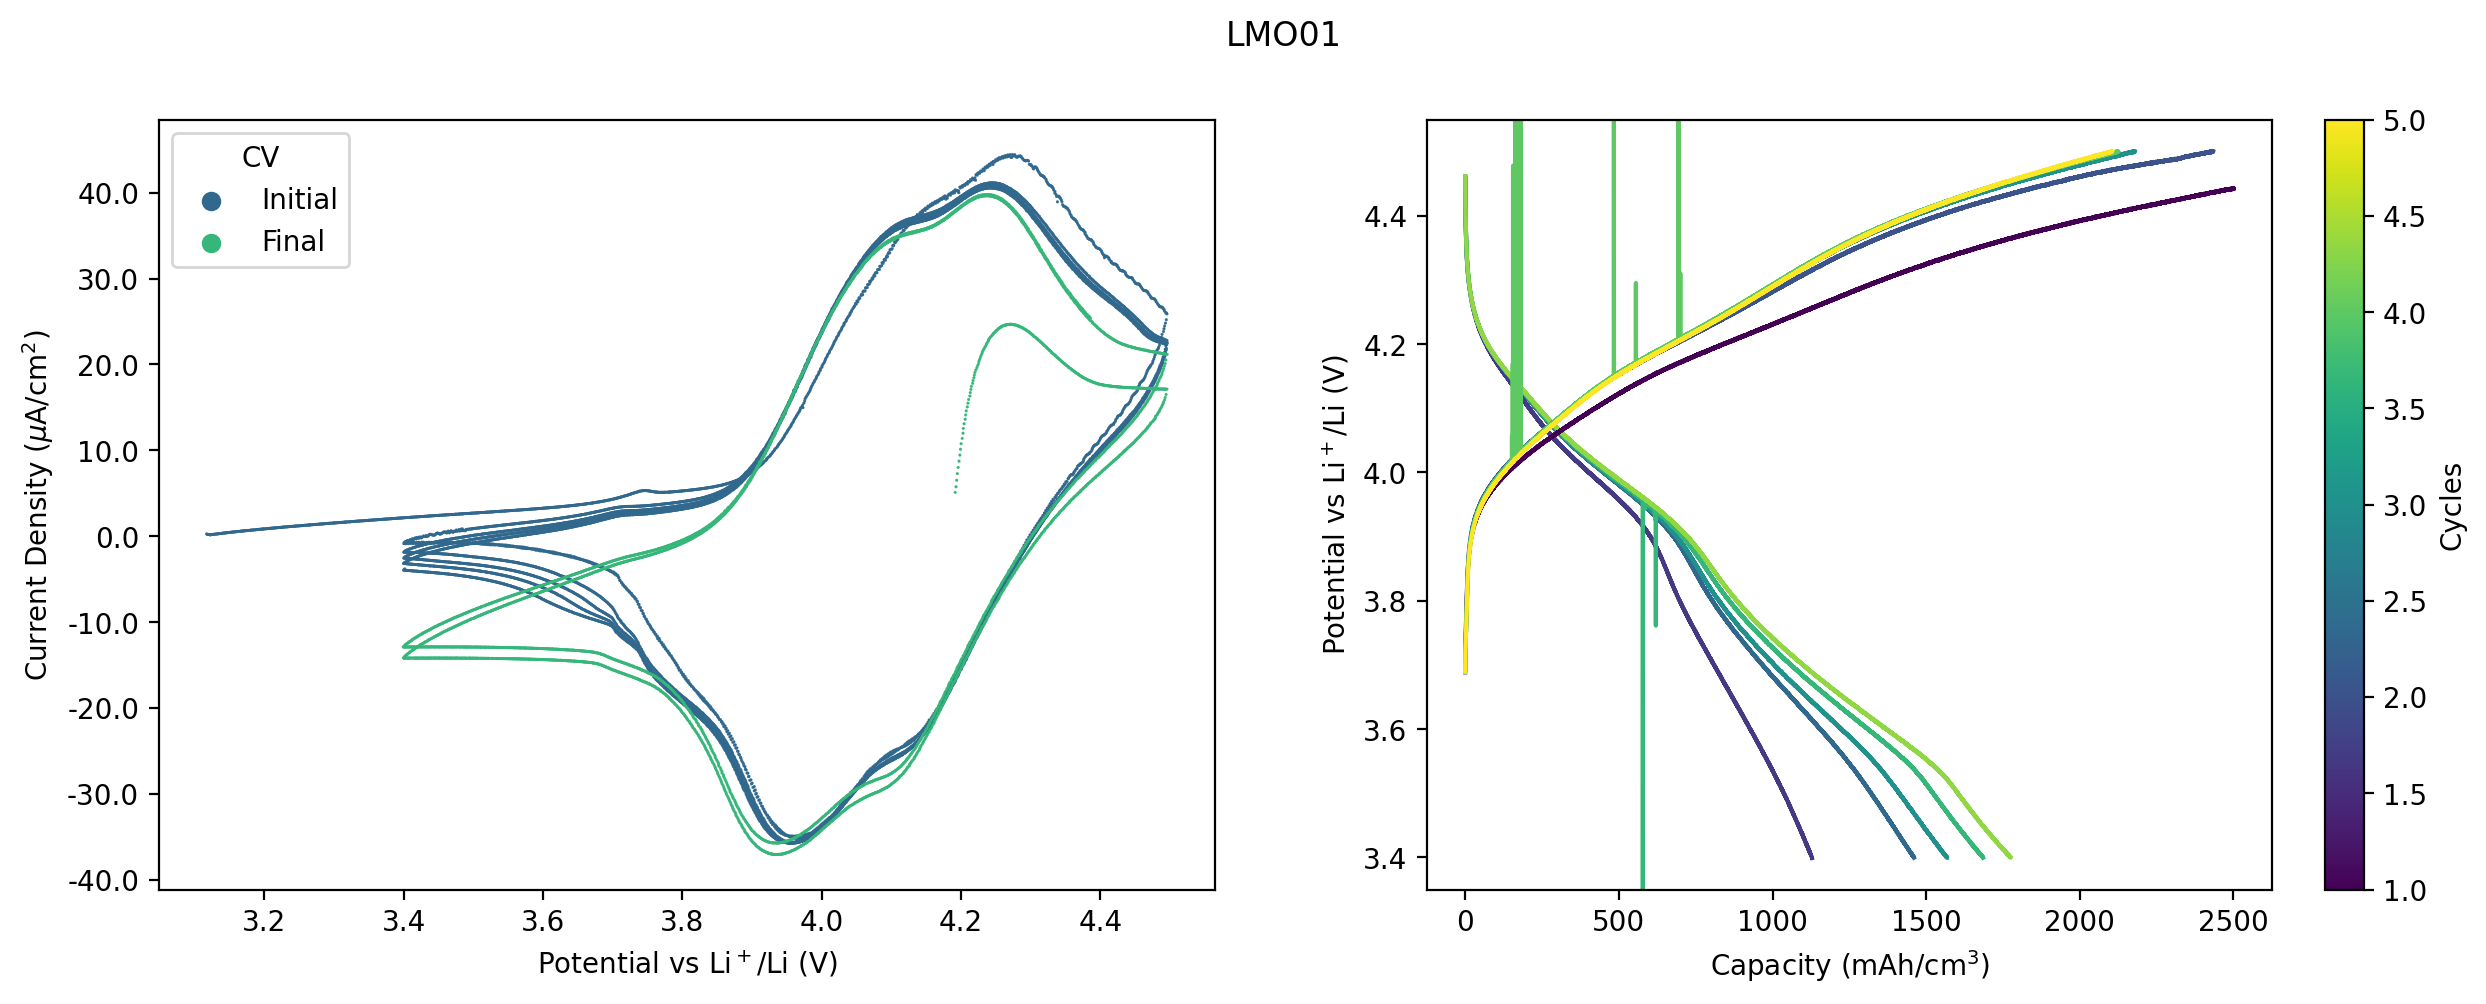

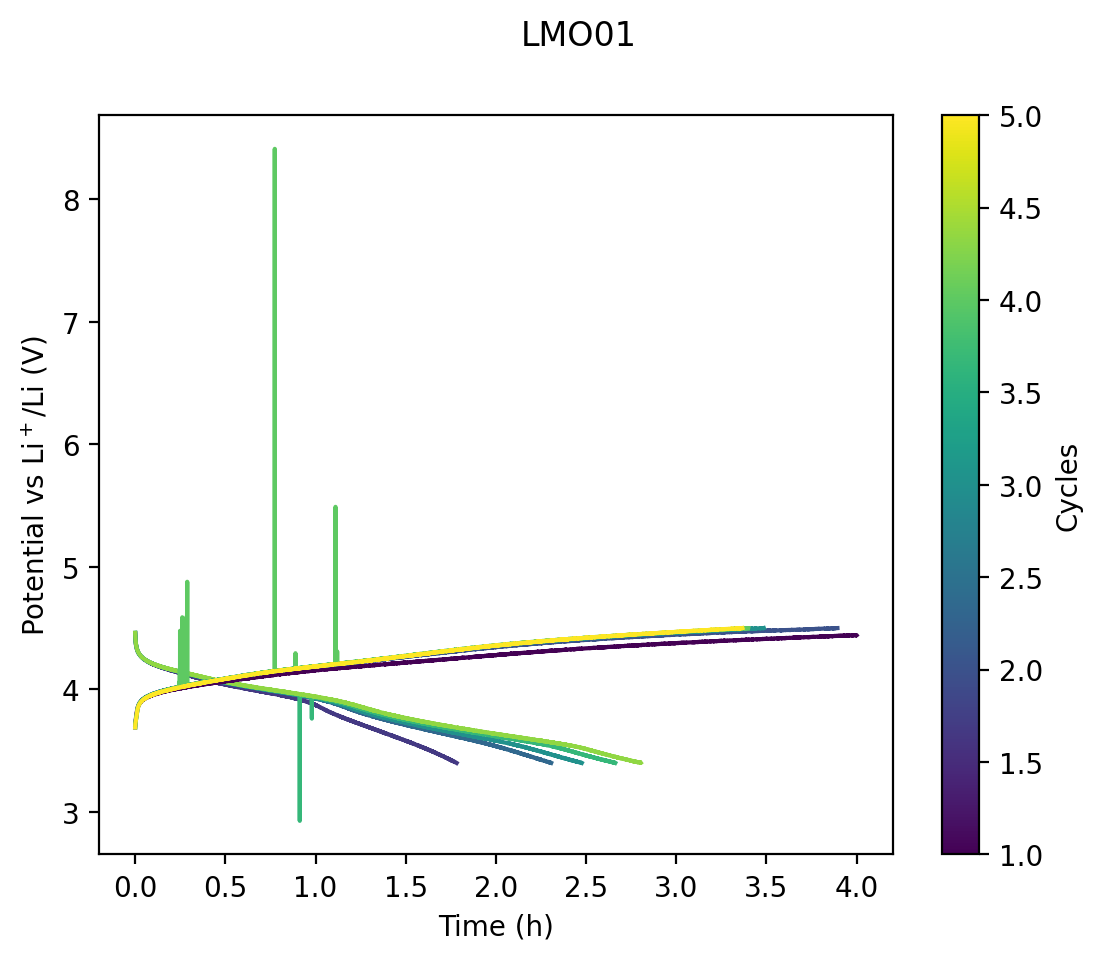

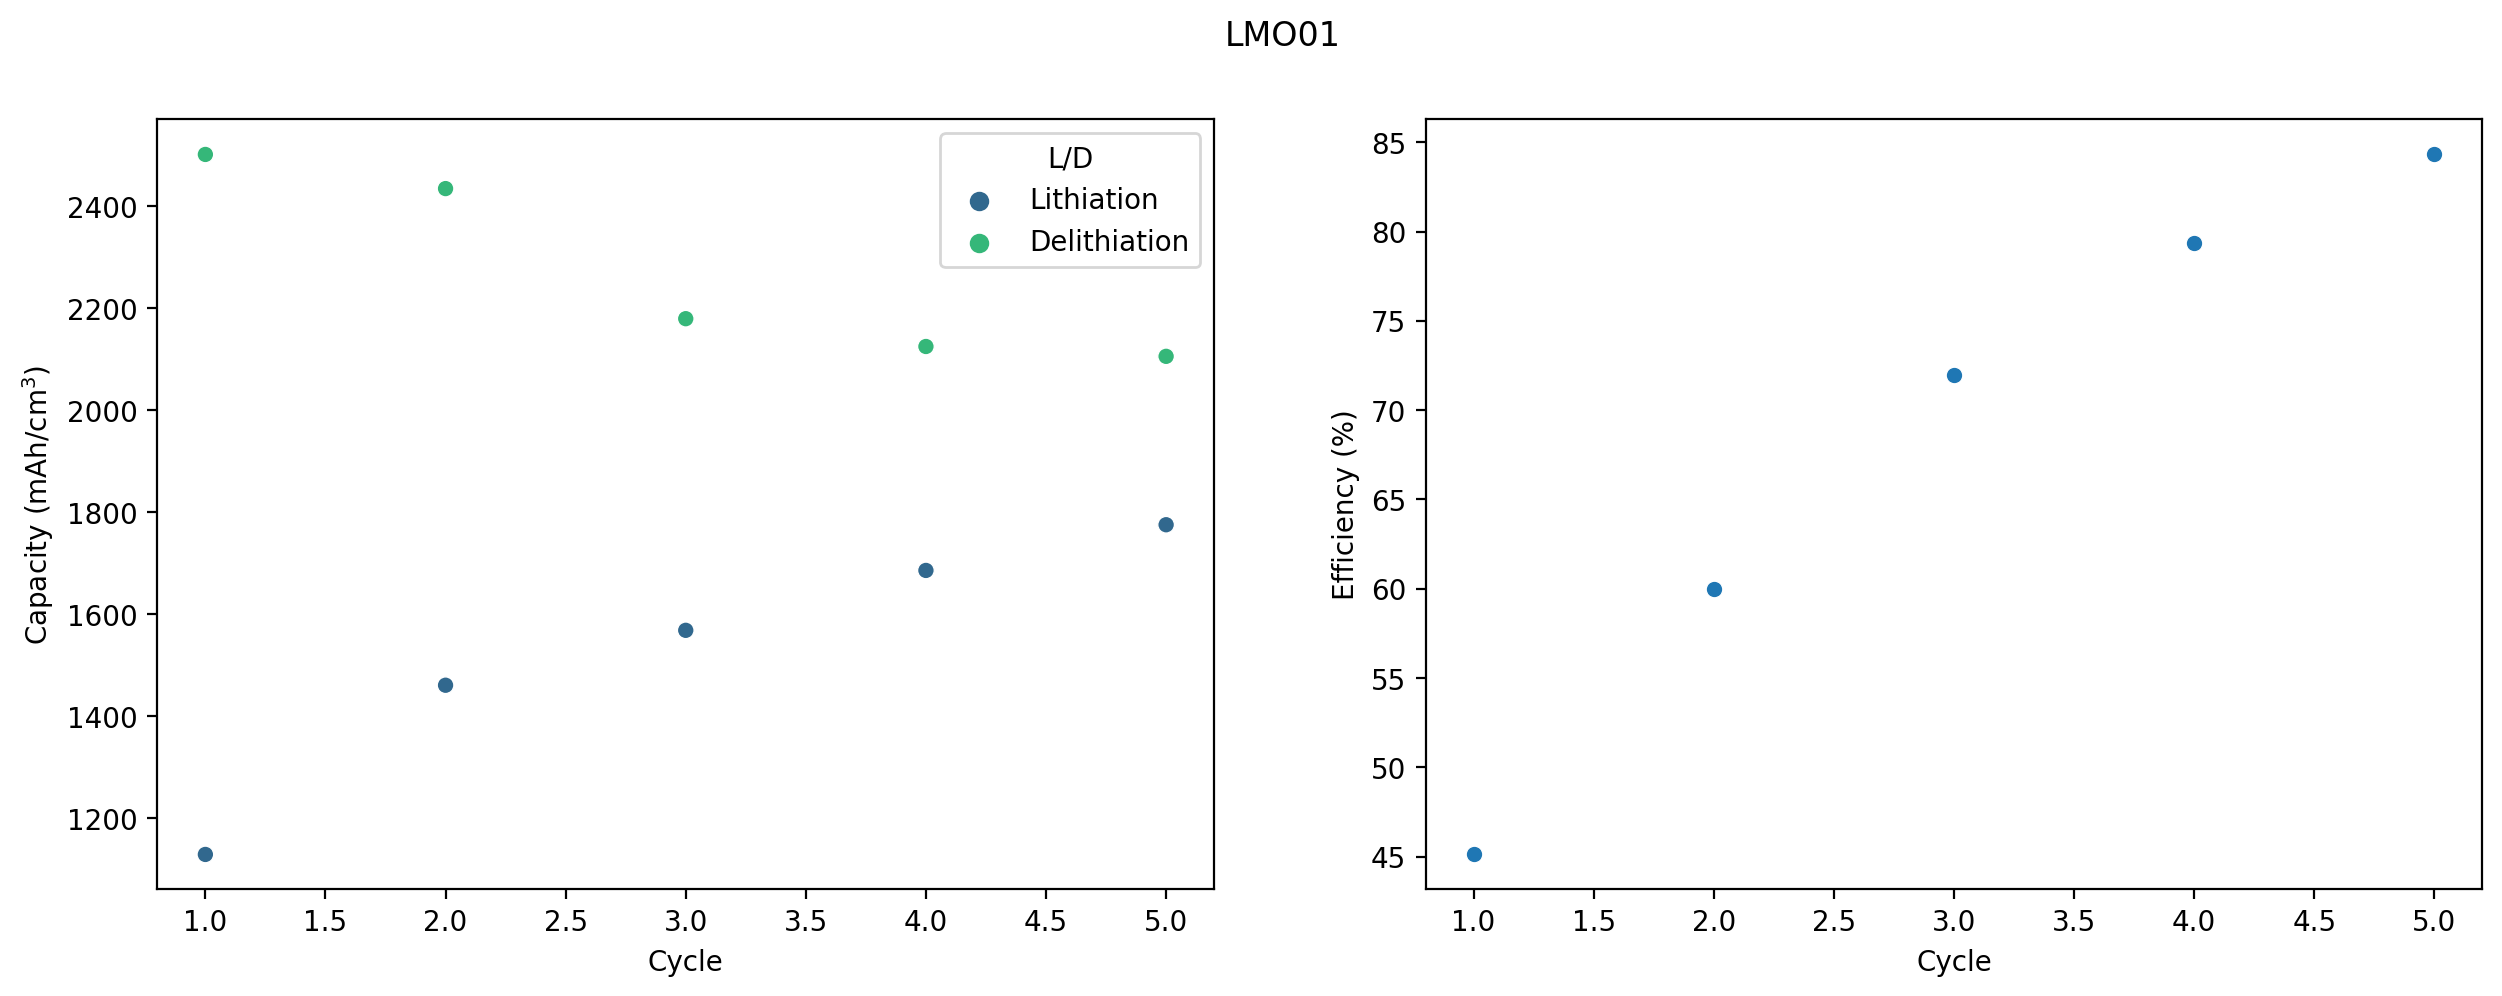

In [19]:
# LMO01 on solid electrolyte LiTFSI:EMi TFSI 2:1 15% PEG
sample = 'LMO01'
area = np.pi * (0.4**2)
thickness = 90 #nm
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\LMO_Jonas_SolidElectrolyte\Run1'
setup_files(path)
lmo01 = cc(path, area, thickness, sample)

cc_plot(lmo01, sample, 200)



In [36]:
# EIS

def cond(r, l, a):
    result = 1e3 / (r*a/l)
    print('{:.3}'.format(result) + ' mS/cm2')
    return 

resistance = 180
area = np.pi * (0.4**2)
thick = 200e-4 # cm

cond(resistance, thick, area)


0.221 mS/cm2
